# Utilities:

Progress bar to keep track of actions like image and label import

In [1]:
# Print progress
def print_progress (iteration, total, message = '', length = 20):
    
    # Calculate percent complete
    percent = "{0:.1f}".format(iteration / total * 100)
    # Determine fill of loading bar, length is the total length
    fill = int(length * iteration / total)
    # Determine the empty space of the loading bar
    empty = ' ' * (length - fill)
    # Animate the bar with unicode character 2588, a filled block
    bar = u"\u2588" * fill + empty
    
    # Print loading bar
    print(f'\r{message} |{bar}| {percent}% ', end = '\r')
   
    # Print new line on completion
    if iteration == total: 
        print()

In [2]:
import time

for i in range(250):
    time.sleep(0.01)
    print_progress(i,250-1,message='Loading images: ')
    
for i in range(100):
    time.sleep(0.01)
    print_progress(i,100-1,message='Loading labels: ')

Loading images:  |████████████████████| 100.0% 
Loading labels:  |████████████████████| 100.0% 


# Task A
## Image and label data import

Loading images from source folders using homemade modules.

/Users/gardar/Documents/UCL/ELEC0134 MLS-I Applied Machine Learning Systems/Assignments
Importing image data...
Image data is stored in numpy array 'X' of size: (5000, 218, 178, 3)
Importing labels...
Label data is stored in Pandas DataFrame 'y' with dimensions: (5000, 4)
Displaying random images and corresponding labels from set...


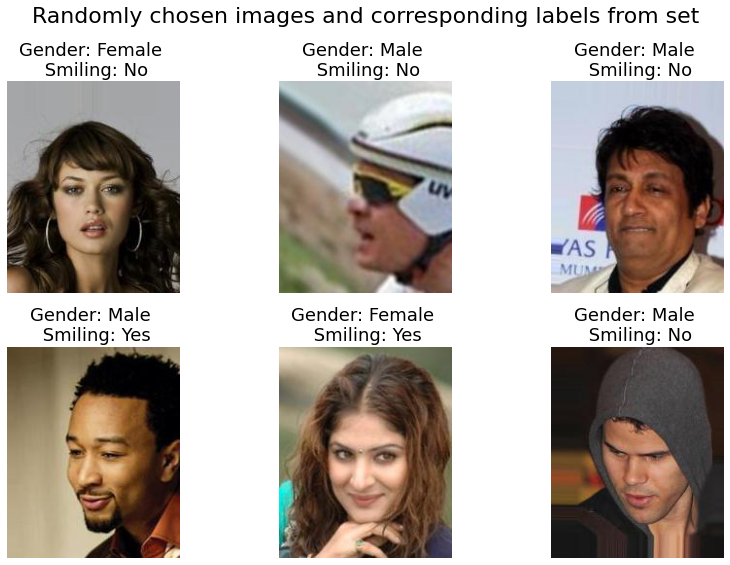

In [3]:
# To modularise the program, we need to add the current directory to sys path
import os
import sys

# Grab the current file path...
currentPath = os.path.dirname(os.path.abspath(os.getcwd()))

print(currentPath)

# ... and append it to the system path
sys.path.append(currentPath)

# Now we can import our own modules into our script.
import Final.code.import_data as ds
import Final.code.split_dataset as sd 

# numpy for enhanced mathematical support
import numpy as np
# Matplotlib for visualisation
import matplotlib.pyplot as plt

# Define a path to the data - REMEMBER TO RESET THIS BEFORE TURNING IN
img_path = "/Users/gardar/Documents/UCL/ELEC0134 MLS-I Applied Machine Learning Systems/Assignments/dataset_AMLS_20-21/celeba/img/"
label_path = "/Users/gardar/Documents/UCL/ELEC0134 MLS-I Applied Machine Learning Systems/Assignments/dataset_AMLS_20-21/celeba/"

# Load image and label data with the novel 'import_data' module
X , y , random_img = ds.dataImport(img_path,label_path,surpress=False,return_img_indices=True)

## Split into testing, validation and training sets

Plotting the dataset split...


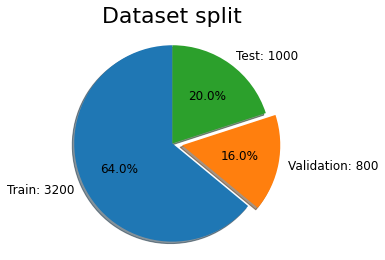

In [4]:
# Split data to train, validation and test sets
Xtrain,Xval,Xtest,ytrain,yval,ytest = sd.split_dataset(X,y,
                                                       test_size=0.2,
                                                       val_size=0.2,
                                                       surpress=False) 

## Task A1
### Classify images on 'gender'

# Pre-process images

We've got a couple of ways of converting the images to grayscale - here I'm comparing how the results vary visually from calculating the mean, $\mu$, over the three `RGB` channels, with *de facto* encoding methods such as Rec 601 (ITU-R Recommendation BT.601) which uses the weights:<br> 
`R ~ 0.3 | G ~ 0.6 | B ~ 0.15`<br>
to flatten the color channels.

In [5]:
# Task A1 determine gender
ytrain_A1 = ytrain.loc[:,'gender']
print(ytrain_A1.shape)
XmeanRGB = Xtrain.mean(axis=3)
print(XmeanRGB.shape)

(3200,)
(3200, 218, 178)


In [6]:
RGB_weights = [0.2989, 0.5870, 0.1140]
XweightRGB = np.dot(Xtrain[...,:3], RGB_weights)

Let me check what the maximum value difference between Weighted and Mean RGB is across all the images:

In [7]:
pixelDiff = XmeanRGB - XweightRGB

In [8]:
print("Highest deviation between the two encoding methods for any individual pixel found to be: {:.2f}".format(pixelDiff.max()))
print("Found at: {}".format(np.where(pixelDiff==pixelDiff.max())))

Highest deviation between the two encoding methods for any individual pixel found to be: 55.84
Found at: (array([813]), array([111]), array([32]))


(-0.5, 177.5, 217.5, -0.5)

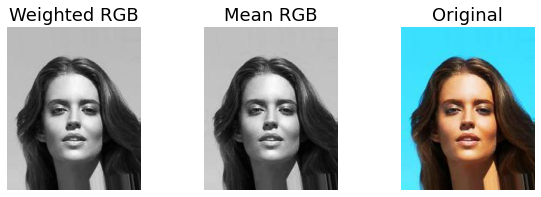

In [9]:
sample = 2516

fig,ax=plt.subplots(1,3,figsize=(10,3))
ax[0].imshow(XweightRGB[sample,...],cmap=plt.get_cmap("gray"))
ax[0].set_title("Weighted RGB")
ax[0].axis("off")
ax[1].imshow(XmeanRGB[sample,...],cmap=plt.get_cmap("gray"))
ax[1].set_title("Mean RGB")
ax[1].axis("off")
ax[2].imshow(Xtrain[sample,...],cmap=plt.get_cmap("gray"))
ax[2].set_title("Original")
ax[2].axis("off")

### Conclusion?

To be frank I don't see too big of a difference between the two methods. It seems there may be a slightly different shade of gray converting certain vibrant colours like purple, likely due to the decreased weights that the `R-B` channels are given. <br>
However there is one important aspect to note here, and it is that the `rgb_weights` key gives us a way to decode the encoded grayscale image back to the `RGB` plane, hence we will chose to use weighted RGB.

## Flatten images for PCA

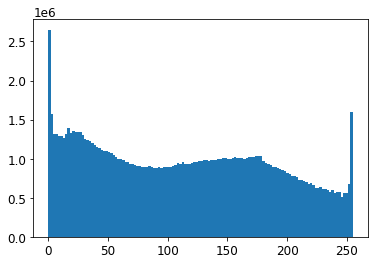

In [10]:
plt.figure()
plt.hist(XweightRGB.flatten(),128)
plt.show()

In [117]:
x,y,z = XweightRGB.shape # Xmean is a three dimensional array
Xtrain_A1 = np.reshape(XweightRGB, (x,y*z)) # We want to reshape it by folding the 2nd and 3rd dimensions, i.e. y,z
print(Xtrain_A1.shape)  # It will output a shape (3200, 38804)

(3200, 38804)


Figure out the mean of the data

In [118]:
Xmean = XweightRGB.mean(axis=0)

Visualise it

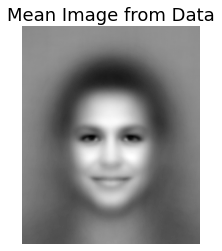

In [119]:
plt.figure()
plt.imshow(Xmean,cmap=plt.get_cmap("gray"))
plt.axis("off")
plt.title("Mean Image from Data")
plt.show()

So our PCA will represent a deviation from this lovely... lady?

That makes me wonder how the data is split with regards to Male / Female samples

In [14]:
# I'll leave this cell here if I wish to check that out later

Center images:

In [121]:
# Let's flatten the mean image from 218 x 178 to 1 x 38804:
Xmean = Xmean.flatten()

# Let's load the centered images to a list using a comprehension
Xcenter = np.array([Xtrain_A1[img,...] - Xmean for img in range(len(Xtrain_A1))])

Check size....

In [122]:
Xcenter.shape

(3200, 38804)

In [123]:
Xcenter.min(),Xcenter.max()

(-172.6744944999998, 195.6364496249999)

In [124]:
#Xcenter[Xcenter<0]=0

In [139]:
Xcenter = np.interp(Xcenter, (Xcenter.min(), Xcenter.max()), (0, 255))

In [140]:
Xcenter.min(),Xcenter.max()

(0.0, 255.0)

Visualise one sample in the name of science

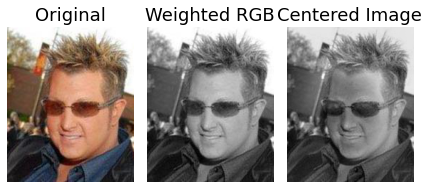

In [141]:
fig,ax = plt.subplots(1,3)
ax[0].imshow(Xtrain[1])
ax[0].axis("off")
ax[0].set_title("Original")
ax[1].imshow(XweightRGB[1].reshape(218,178),cmap=plt.get_cmap("gray"))
ax[1].axis("off")
ax[1].set_title("Weighted RGB")
ax[2].imshow(Xcenter[1].reshape(218,178),cmap=plt.get_cmap("gray"))
ax[2].axis("off")
ax[2].set_title("Centered Image")
plt.tight_layout()
plt.show()

# PCA for dimensionality reduction using SVD

Here we perform principal component analysis on our centered imageset.
We use singular value decomposition to extract the eigenvalues and -vectors from the covariance matrix

In [142]:
Xnorm = Xcenter/255.0
Xnorm.min(),Xnorm.max()

(0.0, 1.0)

In [143]:
U, Sigma, WT = np.linalg.svd(Xnorm, full_matrices=False)

In [144]:
# Verify dimensions of the SVD output
print("Centered data to process X: {}".format(Xcenter.shape))
print("Covariance Matrix U: {}".format(U.shape))
print("Eigenvalues Sigma: {}".format(Sigma.shape))
print("Eigenvectors WT: {}".format(WT.shape))

Centered data to process X: (3200, 38804)
Covariance Matrix U: (3200, 3200)
Eigenvalues Sigma: (3200,)
Eigenvectors WT: (3200, 38804)


## Scree plot
How many features do we really need to accurately describe our imaged data?<br>
This PCA Scree Plot may help us decide.

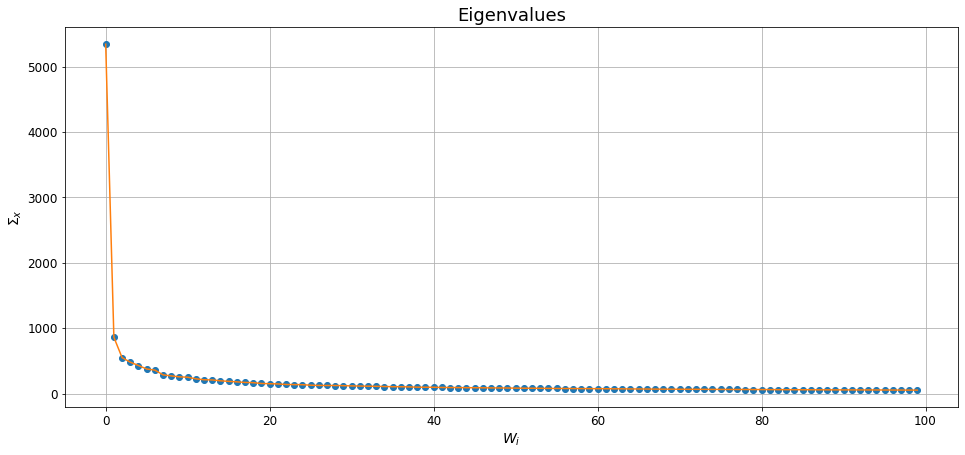

In [145]:
features = 100
plt.figure(figsize=(16,7))
plt.plot(range(features),Sigma[:features],'o')
plt.plot(range(features),Sigma[:features])
plt.xlabel("$W_i$")
plt.ylabel("$\Sigma_{x}$")
plt.title("Eigenvalues")
plt.grid("on")
plt.show()

I get a feeling that anything in between 20 and 40 eigenvectors, i.e. features will do.<br>
This means we have reduced our feature vector from:

\begin{equation}
X = X_{218 \times 178 px} = x_{\#1 px},x_{\#2 px} ... x_{\#38,804 px}
\end{equation}

Where each pixel, $px$, corresponds to a feature, to:

\begin{equation}
X = x_{W_{1}}...x_{W_{30}}
\end{equation}

Where $W_{i}$ are the image's eigenvectors.
The scree plot, where we plot eigenvalues against the 1st, 2nd, etc. eigenvectors displays how much information is carried in every $i$-th dimension. We see somewhat a convergence at $W_{i=20}$, which indicates that only about the 20 first factors can be interpreted as statistically significant.

In [146]:
Xtrain_A1_DR = Xnorm*WT # DR = Dimensionally Reduced
Xtrain_A1_DR = Xtrain_A1_DR[:,:30]
Xtrain_A1_DR.shape

(3200, 30)

In [147]:
Xtrain_A1_DR.max()

0.012591322158454168

Let's plot these eigenfaces...

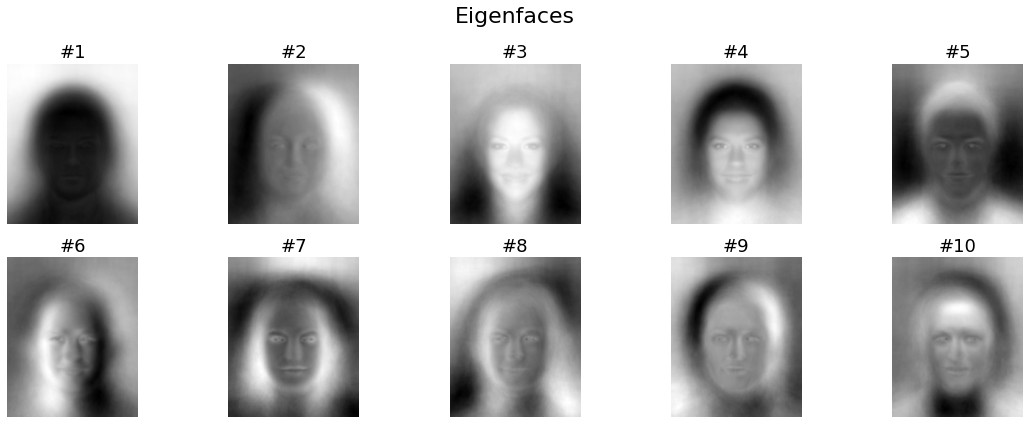

In [148]:
fig,ax = plt.subplots(2,5,figsize=(16,6))
row,col = ax.shape

k = 1 # 1D iterator

for i in range(row):
    for j in range(col):
        ax[i,j].imshow(np.reshape(WT[k,:], (218,178)),cmap=plt.get_cmap("gray"))
        ax[i,j].axis("off")
        ax[i,j].set_title("#{}".format(k))
        k+=1 # Just to plot 

plt.suptitle("Eigenfaces")
plt.tight_layout()
plt.show()

## PCA with scikit learn

In [135]:
from sklearn.decomposition import PCA
import pandas as pd

Grayscales have values 0-255

In [28]:
np.min(Xtrain_A1),np.max(Xtrain_A1)

(0.0, 254.9745)

Normalise values to 0-1

In [29]:
Xtrain_A1_norm = Xtrain_A1 / 255
np.min(Xtrain_A1_norm),np.max(Xtrain_A1_norm)

(0.0, 0.9999)

Create an object of class PCA

In [30]:
Xtrain_A1_PCA = PCA(n_components = 30)

Fit the data

In [31]:
Xtrain_A1_PrincipalComponents = Xtrain_A1_PCA.fit_transform(Xtrain_A1_norm)

Store in a dataframe

In [32]:
columnNames = ['PC #{}'.format(component) for component in range(Xtrain_A1_PrincipalComponents.shape[1])]
Xtrain_A1_PCA_DF = pd.DataFrame(data = Xtrain_A1_PrincipalComponents,
                                columns = columnNames)

Show the first few items

In [33]:
Xtrain_A1_PCA_DF

,PC #0,PC #1,PC #2,PC #3,PC #4,PC #5,PC #6,PC #7,PC #8,PC #9,...,PC #20,PC #21,PC #22,PC #23,PC #24,PC #25,PC #26,PC #27,PC #28,PC #29
0,53.028490,21.339996,4.829437,-7.409897,-12.685578,4.878660,-2.244760,0.193574,-0.561590,6.111980,...,2.484903,-7.823742,-0.211066,-1.484754,5.992015,-4.961550,-6.016698,1.952602,4.991393,-1.535306
1,13.070235,-20.175664,13.064146,16.065921,-2.920450,5.852899,-7.880176,-18.872685,2.813932,2.549115,...,5.647861,-1.474400,4.453958,-0.276403,-1.548045,1.659996,-1.427377,1.010679,1.668581,0.370044
2,24.081081,-20.261869,12.602837,-5.559767,-14.583201,-0.598236,11.789155,1.137308,7.912645,0.403616,...,-6.854347,-1.554937,-0.796961,0.070173,-2.620407,2.140595,2.514076,-0.050219,-3.143880,-1.884073
3,15.467545,-26.709063,7.424836,0.271464,0.933587,-0.353651,-2.025641,-0.670493,1.882401,3.073435,...,0.537461,-2.402207,0.302780,0.788744,0.126182,0.252796,2.985748,5.346618,-1.877724,2.708632
4,15.595831,11.156265,0.411333,8.044458,-0.335384,0.658226,5.184069,0.492756,-0.298151,0.799082,...,-0.673446,-1.869686,-1.521257,-2.395111,-4.034814,3.336979,0.740082,1.719300,-2.516347,0.322436


Check out the information carried in each component

In [34]:
print('Explained variation per principal component: \n{}'.format(Xtrain_A1_PCA.explained_variance_ratio_))

Explained variation per principal component: 
[0.36858873 0.07172281 0.06469561 0.04290127 0.03435308 0.03019343
 0.02750331 0.01728922 0.01555428 0.01391865 0.01332524 0.01074649
 0.0092397  0.00911739 0.0080668  0.00742917 0.00679906 0.00615497
 0.00589236 0.0050164  0.00479911 0.00457955 0.00408343 0.00397832
 0.00387889 0.00347006 0.00327313 0.00322521 0.00320523 0.00306086]


Visualize ... **Scree plot**

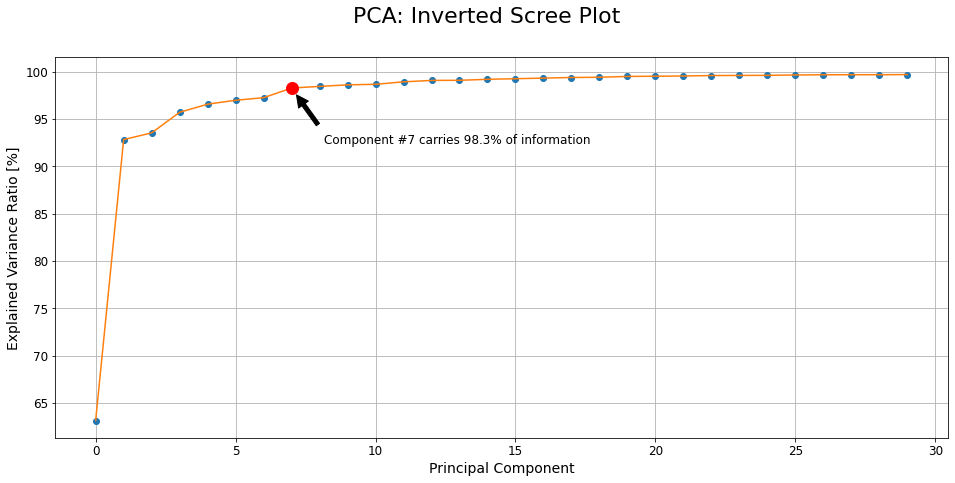

In [35]:
plt.figure(figsize=(16,7))

plt.plot(range(30),(1-Xtrain_A1_PCA.explained_variance_ratio_)*100,'o')
plt.plot(range(30),(1-Xtrain_A1_PCA.explained_variance_ratio_)*100)
plt.plot(7,(1-Xtrain_A1_PCA.explained_variance_ratio_[7])*100,'ro',markersize=12)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio [%]")

convX,convY = 7,(1-Xtrain_A1_PCA.explained_variance_ratio_[7])*100

plt.annotate("Component #{} carries {:.1f}% of information".format(convX,convY), 
             xy=(convX,convY),
             xycoords='data',
             xytext=(0.6, 0.8), 
             textcoords='axes fraction',
             arrowprops=dict(facecolor='black',shrink=0.15),
             horizontalalignment='right', 
             verticalalignment='top',
            )

plt.grid("on")
plt.suptitle("PCA: Inverted Scree Plot")
plt.show()

In [36]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


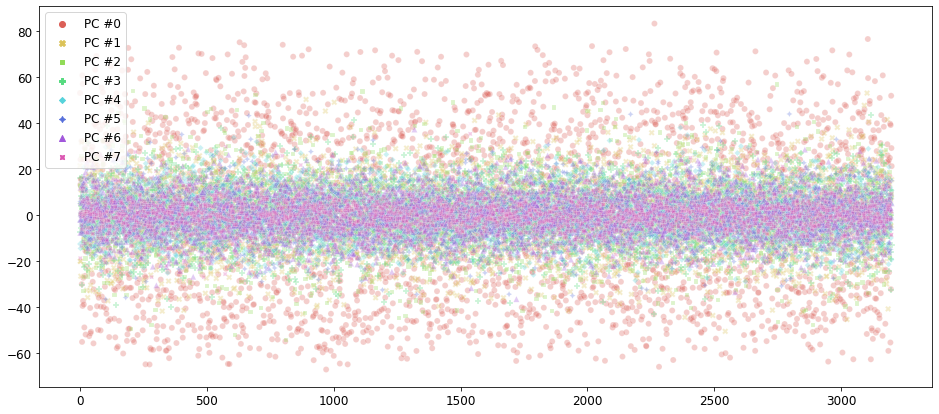

In [37]:
import seaborn as sns

plt.figure(figsize=(16,7))
sns.scatterplot(
    palette=sns.color_palette("hls", 8),
    data=Xtrain_A1_PCA_DF.loc[:,"PC #0":"PC #7"],#.loc[:,("PC #0","PC #1")],
    legend="full",
    alpha=0.3
)
plt.show()

# PCA for 90% variance

Do PCA but here order a certain variance (i.e. capture 90% of the variance)

In [38]:
pca = PCA(0.9)

In [39]:
Xtrain_A1_PC = pca.fit(Xtrain_A1_norm)

See how many components were needed

In [40]:
pca.n_components_

115

Ok, so I must have misinterpreted in my previous analysis.

# Import some ML stuff...

In [46]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.optimizers import RMSprop

## Reduce Dimensions of Images

We'll now transform our training data

In [47]:
train_img_pca = pca.transform(Xtrain_A1_norm)

Should be 3200 images with 115 features each

In [48]:
train_img_pca.shape

(3200, 115)

Now convert our validation data (and do all the necessary preprocessing while we're at it)

In [49]:
XvalGRY = np.dot(Xval[...,:3], RGB_weights)
x,y,z = XvalGRY.shape # Xmean is a three dimensional array
Xval_A1 = np.reshape(XvalGRY, (x,y*z)) # We want to reshape it by folding the 2nd and 3rd dimensions, i.e. y,z
Xval_A1_norm = Xval_A1 / 255
val_img_pca = pca.transform(Xval_A1_norm)
val_img_pca.shape

(800, 115)

## Get Label Data Sorted
Get our training labels sorted

In [73]:
ytrain_A1=ytrain.loc[:,('gender','smiling')]
ytrain_A1[ytrain_A1<0]=0
ytrain_A1.head()

,gender,smiling
1903,1,1
4589,1,1
918,0,1
909,0,1
324,0,1


...and validation labels

In [74]:
yval_A1=yval.loc[:,('gender','smiling')]
yval_A1[yval_A1<0]=0
yval_A1.head()

,gender,smiling
4609,1,0
2123,1,1
3414,0,1
3780,0,1
4693,1,1


In [88]:
batch_size = 128
num_classes = 2
epochs = 20

In [89]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(115,)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [90]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 1024)              118784    
_________________________________________________________________
dense_32 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_33 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_34 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 514       
Total params: 1,825,026
Trainable params: 1,825,026
Non-trainable params: 0
_________________________________________________________________


In [91]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(train_img_pca, ytrain_A1,batch_size=batch_size,epochs=epochs,verbose=1,
                    validation_data=(val_img_pca, yval_A1))

Train on 3200 samples, validate on 800 samples
Epoch 1/20
3200/3200 [==============================] - 1s 410us/step - loss: 4.4180 - accuracy: 0.5356 - val_loss: 8.7950 - val_accuracy: 0.6737
Epoch 2/20
3200/3200 [==============================] - 1s 192us/step - loss: 92.6129 - accuracy: 0.5084 - val_loss: 130.7703 - val_accuracy: 0.7387
Epoch 3/20
3200/3200 [==============================] - 1s 192us/step - loss: 671.8406 - accuracy: 0.5156 - val_loss: 274.5756 - val_accuracy: 0.4475
Epoch 4/20
3200/3200 [==============================] - 1s 191us/step - loss: 1864.7226 - accuracy: 0.5056 - val_loss: 4933.3279 - val_accuracy: 0.4913
Epoch 5/20
3200/3200 [==============================] - 1s 193us/step - loss: 4646.5993 - accuracy: 0.5213 - val_loss: 3211.9446 - val_accuracy: 0.7387
Epoch 6/20
3200/3200 [==============================] - 1s 193us/step - loss: 9041.0557 - accuracy: 0.5066 - val_loss: 32463.0600 - val_accuracy: 0.7387
Epoch 7/20
3200/3200 [=============================

In [92]:
n,x,y,z = Xtrain.shape
Xtrain_FI = Xtrain.reshape(n,(x*y*z))
n,x,y,z = Xval.shape
Xval_FI = Xval.reshape(n,(x*y*z))
Xtrain_FI.shape,Xval_FI.shape

((3200, 116412), (800, 116412))